In [1]:
# TODO: derive + implement stance phase
# TODO: implement refresh rate for different controllers
# TODO: implement sensor noise
# TODO: implement impact detection
# TODO: implement smarter gait scheduler (support polygon?)

In [2]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time as t
import itertools
import numpy as np
import random

import leg_controller as con
import gait_scheduler as gs
import pd_controller as pd

from tqdm.auto import tqdm

/home/jack/Documents/School/Thesis/Thesis/MS-Thesis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model and create MjData and Renderer objects to go along with it

$\texttt{model}$ contains all information about the robot/environment; this includes all parts, links, joints, and the ground.

$\texttt{data}$ contains all information about the state of $\texttt{model}$. We can read information about the environment's state here, and apply forces at joints. This is where all the physics modeling takes place.

$\texttt{renderer}$ contains all necessary information to render the scene.

In [3]:
# simulation environment
model = mujoco.MjModel.from_binary_path("Quadruped MJB.mjb")
data = mujoco.MjData(model)

# visualization
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
camera.distance = 1.5
camera.trackbodyid = 2
# side view
if True:
    camera.azimuth = 0  # horizontal camera panning
    camera.elevation = -2  # camera height off the ground
# isometric view
if False:
    camera.azimuth = 30

# model configuration
model.opt.gravity = (0, 0, -9.81)  # set simulation gravity
model.opt.integrator = 1  # select integrator (0 = Euler, 1 = implicitfast, 2 = implicit, 3 = rk4)
model.opt.timestep = .0005  # set timestep

# create the controller objects
gait_scheduler = gs.gait_scheduler()
fr_leg = con.leg_controller()
fl_leg = con.leg_controller()
rr_leg = con.leg_controller()
rl_leg = con.leg_controller()
legs = (fr_leg, fl_leg, rr_leg, rl_leg)
pd_controller = pd.PD()

## Define functions for running the robot's controllers

$\texttt{model\_to\_abs()}$ accounts for zero offsets and incorrect axis directions, and $\texttt{abs\_to\_model()}$ does the reverse conversion. These functions are necessary because the .mjb file for the robot does not have the joints zeroed in the correct place; ideally this would be fixed in the model, but due to the poor performance of the Solidworks to URDF extension, this option is preferred.

In [4]:
def model_to_abs(mod_pos):
    pos_offsets = np.array([
        .736600934, -1.51121634, .737159549, -1.51177616, .736600879,
        -1.51121629, .737164507, -1.51177608
    ])

    abs_pos = mod_pos - pos_offsets
    return abs_pos


def abs_to_model(abs_pos):
    pos_offsets = np.array([
        .736600934, -1.51121634, .737159549, -1.51177616, .736600879,
        -1.51121629, .737164507, -1.51177608
    ])

    mod_pos = abs_pos + pos_offsets
    return mod_pos

# Estimate the state
This function performs all the state estimation the robot needs to operate.

$$ \texttt{data.qpos} = [x, y, z , pitch , roll , yaw , fr\_hip , fr\_knee , fl\_hip , fl\_knee , rr\_hip , rr\_knee , rl\_hip , rl\_knee] $$

$$ \texttt{data.qvel} = [\dot{x}, \dot{y}, \dot{z} , \dot{pitch} , \dot{roll} , \dot{yaw} , \dot{fr\_hip} , \dot{fr\_knee} , \dot{fl\_hip} , \dot{fl\_knee} , \dot{rr\_hip} , \dot{rr\_knee} , \dot{rl\_hip} , \dot{rl\_knee}] $$

In [5]:
def state_estimation(model, data):
    # get 'sensor data' (add noise if needed)
    curr_pos = data.qpos  # + np.random.rand(14)*.01
    curr_pos = np.concatenate((curr_pos[1:7], model_to_abs(curr_pos[7:15])))
    curr_vel = data.qvel  # + np.random.rand(14)*.01
    curr_forces = data.qfrc_inverse[6:]  # + np.random.rand(14)*.01

    #print(curr_pos[6:])

    # do stuff for each leg
    i = 0
    window_len = 100
    for leg in legs:
        # update the leg's current position
        leg.curr_pos = curr_pos[6 + 2 * i:8 + 2 * i]
        #print(leg.curr_pos)
        # update the body attitude
        leg.pitch = curr_pos[3]
        leg.roll = curr_pos[4]
        leg.yaw = curr_pos[5]
        # update the body velocity
        leg.pitch_vel = curr_vel[3]
        leg.roll_vel = curr_vel[4]
        leg.yaw_vel = curr_vel[5]
        # update the moving average leg forces
        leg.avg_force[0] = (
            leg.avg_force[0] *
            (window_len - 1)) / window_len + curr_forces[2 * i] / window_len
        leg.avg_force[1] = (leg.avg_force[1] *
                            (window_len - 1)) / window_len + curr_forces[
                                2 * i + 1] / window_len
        # update the leg force
        leg.curr_force[0] = curr_forces[2 * i]
        leg.curr_force[1] = curr_forces[2 * i + 1]
        # detect contact
        leg.detect_contact()
        # increment the counter
        i = i + 1


state_estimation(model, data)


# Run the controller
This function runs each of the controllers as well as handling the passing of information/commands between controllers

$ \texttt{data.actuator} = ['kd\ fl\ hip', 'kd\ fl\ knee', 'kd\ fr\ hip', 'kd\ fr\ knee', 'kd\ rl\ hip', 'kd\ rl\ knee', 'kd\ rr\ hip', 'kd\ rr\ knee', 'kp\ fl\ hip', 'kp\ fl\ knee', 'kp\ fr\ hip', 'kp\ fr\ knee', 'kp\ rl\ hip', 'kp\ rl\ knee', 'kp\ rr\ hip', 'kp\ rr\ knee']$

In [6]:
def update_controller(model, data):
    # assign memory
    desired = np.zeros(8)
    actual = np.zeros(8)

    # run gait scheduling layer
    gait_scheduler.time = data.time
    gait_scheduler.fixed_time_walk(fr_leg, fl_leg, rr_leg, rl_leg)

    # run leg control layer
    i = 0
    for leg in legs:
        desired[2 * i:2 * i + 2] = leg.run_controller(data.time)
        #print(leg.curr_pos)
        i = i + 1

    # run PD layer
    curr_forces = data.qfrc_inverse
    curr_vel = data.qvel[6:14]  # possible point of error
    i = 0
    # choose the correct feedback variable
    for leg in legs:
        # position control
        if leg.control_type == 0:
            # the actual position is the current position with offsets applied (offests are applied after for loop)
            actual[2 * i] = leg.curr_pos[0]
            actual[2 * i + 1] = leg.curr_pos[1]
            # the desired position is the controller output with the offsets applied (offsets are applied after for loop)
            desired[2 * i] = desired[2 * i]
            desired[2 * i + 1] = desired[2 * i + 1]
        # force control
        elif leg.control_type == 1:
            # the actual force is the current force
            actual[2 * i] = curr_forces[2 * i + 6]
            actual[2 * i + 1] = curr_forces[2 * i + 7]
            # the desired force is the controller output with no offsets applied, so no changes are necessary
        i = i + 1

    i = 0
    for leg in legs:
        data.ctrl[2 * i:2 * i + 2] = pd_controller.run_pd(
            leg, desired[2 * i:2 * i + 2], actual[2 * i:2 * i + 2],
            curr_vel[2 * i:2 * i + 2])
        i = i + 1


update_controller(model, data)

# Simulate, render, and record the behaviour of the system

In [7]:
# define parameters of rendering and sim
duration = 1  # (seconds)
framerate = 30  # (Hz)
n_steps = int(duration / model.opt.timestep + 1)

# allocate memory for arrays
frames = []
positions = np.zeros((n_steps, model.nv))
forces = np.zeros((n_steps, model.nv))
avg_forces = np.zeros((n_steps, model.nv))
contacts = np.zeros((n_steps, 4))
control_input = np.zeros((n_steps, 8))
controller_time = np.zeros(n_steps)
states = np.zeros((n_steps,4))
time = np.zeros(n_steps)
energy = np.zeros((n_steps,3))

# Simulate and display video.
mujoco.mj_resetData(model, data)  # Reset state and time.
i = 0
for i in tqdm(range(n_steps)):
    # step the simulator
    mujoco.mj_step(model, data)
    mujoco.mj_inverse(model, data)

    # estimate the state
    state_estimation(model, data)

    # apply control
    temp = t.time()
    update_controller(model, data)
    controller_time[i] = t.time() - temp

    # store any data we need stored (lower resolution to save on time)
    positions[i] = np.concatenate(
        (data.qpos[:6], model_to_abs(data.qpos[7:15])))
    time[i] = data.time
    forces[i] = data.qfrc_inverse
    avg_forces[i] = np.array(
        np.concatenate(([0], [0], [0], [0], [0], [0], fr_leg.avg_force,
                        fl_leg.avg_force, rr_leg.avg_force, rl_leg.avg_force)))
    contacts[i] = np.array(
        [fr_leg.contact, fl_leg.contact, rr_leg.contact, rl_leg.contact])
    states[i] = np.array([fl_leg.state,fr_leg.state,rl_leg.state,rr_leg.state])
    control_input[i] = data.ctrl
    energy[i] = [data.energy[0],data.energy[1],data.energy[0] + data.energy[1]]

    # render the scene if we're at the correct timestep to have a frame
    if len(frames) < data.time * framerate:
        #camera.azimuth = data.time*75
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate)

100%|██████████| 2001/2001 [00:01<00:00, 1397.77it/s]


# Interpret the recorded data

### Plot the joint positions

[-0.01143747 -0.01300951  0.22136072  0.9997613   0.01301729 -0.01277582
 -1.04799163  1.57045066 -0.83475483  1.5443458  -0.8412829   1.5380699
 -0.88200984  1.4279276 ]


Text(0.5, 1.0, 'Joint Positions')

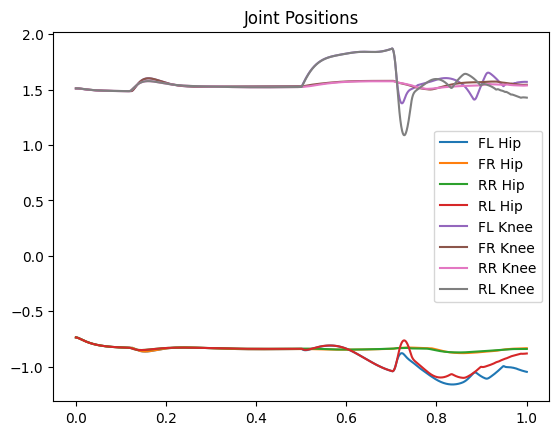

In [8]:
print(positions[-1, :])
plt.plot(time, np.array(positions[:, 6]), label='FL Hip')
plt.plot(time, np.array(positions[:, 8]), label='FR Hip')
plt.plot(time, np.array(positions[:, 10]), label='RR Hip')
plt.plot(time, np.array(positions[:, 12]), label='RL Hip')
plt.plot(time, np.array(positions[:, 7]), label='FL Knee')
plt.plot(time, np.array(positions[:, 9]), label='FR Knee')
plt.plot(time, np.array(positions[:, 11]), label='RR Knee')
plt.plot(time, np.array(positions[:, 13]), label='RL Knee')
plt.legend()
plt.title("Joint Positions")

### Plot the contact forces

Text(0.5, 1.0, 'Joint Forces')

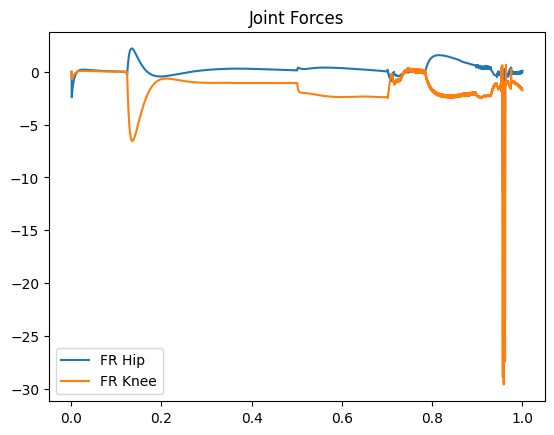

In [9]:
#plt.plot(time,np.array(forces[:,6]),label='FL Hip')
plt.plot(time,np.array(forces[:,8]),label='FR Hip')
#plt.plot(time,np.array(forces[:,10]),label='RR Hip')
#plt.plot(time,np.array(forces[:,12]),label='RL Hip')
#plt.plot(time,np.array(forces[:,7]),label='FL Knee')
plt.plot(time,np.array(forces[:,9]),label='FR Knee')
#plt.plot(time, np.array(forces[:, 11]), label='RR Knee')
#plt.plot(time, np.array(forces[:, 13]), label='RL Knee')
plt.legend()
plt.title("Joint Forces")

### Plot the derivative of the contact forces

Text(0.5, 1.0, 'Joint Force Derivatives')

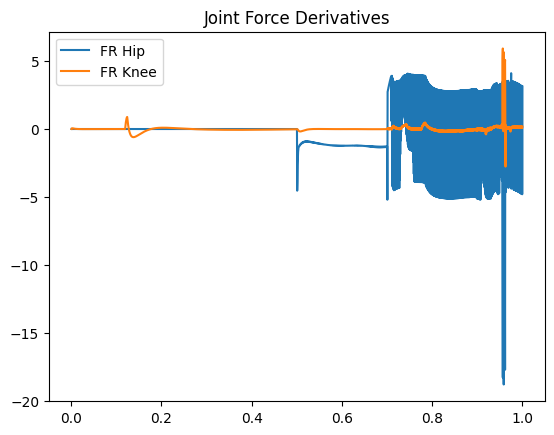

In [10]:
d_forces = np.gradient(forces, 1, axis=1)
#plt.plot(time,np.array(d_forces[:,6]),label='FL Hip')
plt.plot(time,np.array(d_forces[:,8]),label='FR Hip')
#plt.plot(time,np.array(d_forces[:,10]),label='RR Hip')
#plt.plot(time,np.array(d_forces[:,12]),label='RL Hip')
#plt.plot(time,np.array(d_forces[:,7]),label='FL Knee')
plt.plot(time,np.array(d_forces[:,9]),label='FR Knee')
#plt.plot(time, np.array(d_forces[:, 11]), label='RR Knee')
#plt.plot(time, np.array(d_forces[:, 13]), label='RL Knee')
plt.legend()
plt.title("Joint Force Derivatives")


### Compare the forces with their filtered counterparts

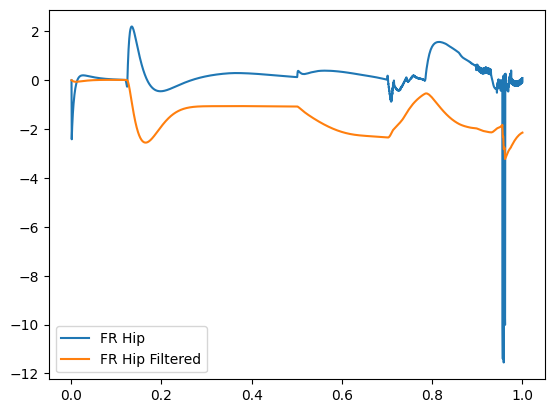

In [11]:
plt.plot(time, np.array(forces[:, 8]), label='FR Hip')
plt.plot(time, np.array(avg_forces[:, 9]), label='FR Hip Filtered')
plt.legend()

### Plot the (estimated) contacts

Text(0.5, 1.0, 'Foot contacts')

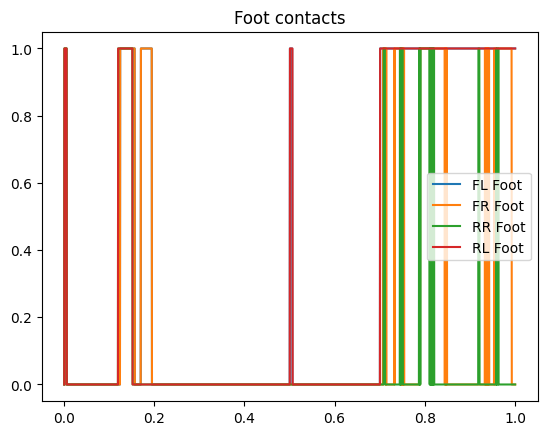

In [12]:
plt.plot(time, np.array(contacts[:, 0]), label='FL Foot')
plt.plot(time, np.array(contacts[:, 1]), label='FR Foot')
plt.plot(time, np.array(contacts[:, 2]), label='RR Foot')
plt.plot(time, np.array(contacts[:, 3]), label='RL Foot')
plt.legend()
plt.title("Foot contacts")

### Plot the state of each leg

Text(0.5, 1.0, 'Leg States')

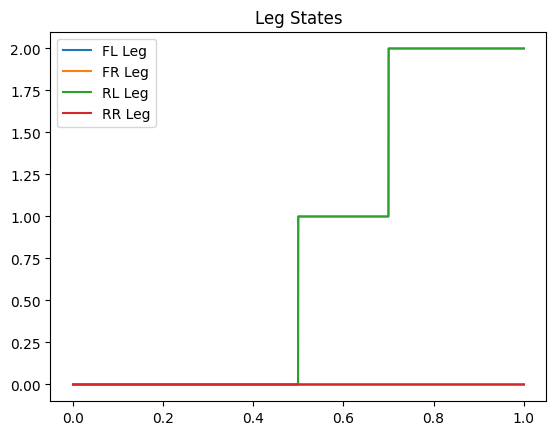

In [13]:
plt.plot(time,states[:,0],label='FL Leg')
plt.plot(time,states[:,1],label='FR Leg')
plt.plot(time,states[:,2],label='RL Leg')
plt.plot(time,states[:,3],label='RR Leg')
plt.legend()
plt.title("Leg States")

### Compare the joint forces to the leg's state for the FL leg

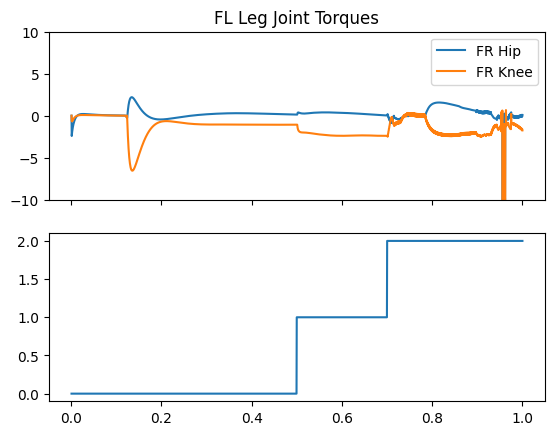

In [14]:
fig,ax = plt.subplots(nrows = 2,ncols = 1,sharex = True)
ax[0].plot(time, np.array(forces[:, 8]), label='FR Hip')
ax[0].plot(time, np.array(forces[:, 9]), label='FR Knee')
ax[0].set_ylim([-10,10])
ax[0].legend()
ax[0].set_title("FL Leg Joint Torques")
ax[1].plot(time,states[:,1],label='FL Leg')

### Plot the control inputs

/tmp/ipykernel_80727/4205931857.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


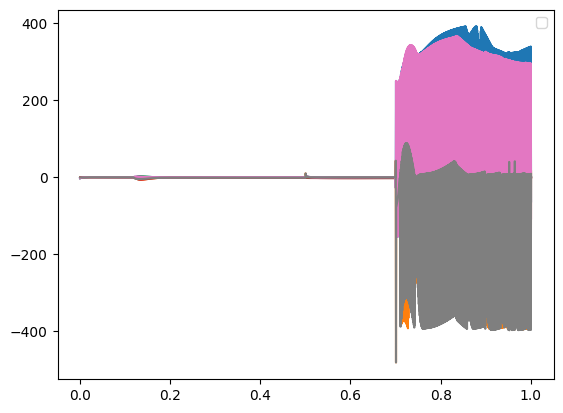

In [15]:
plt.plot(time,control_input[:,0])
plt.plot(time,control_input[:,1])
plt.plot(time,control_input[:,2])
plt.plot(time,control_input[:,3])
plt.plot(time,control_input[:,4])
plt.plot(time,control_input[:,5])
plt.plot(time,control_input[:,6])
plt.plot(time,control_input[:,7])
plt.legend()

# Time the functions

In [16]:
print(f"Average Controller Step Time: {np.mean(controller_time)} seconds")

temp = t.time()
fr_leg.bezier(fr_leg.flight_traj_x, fr_leg.flight_traj_y)
print(f"Bezier curve generation time: {t.time() - temp}")

temp = t.time()
fr_leg.init(1)
print(f"Init state time: {t.time() - temp}")

temp = t.time()
fr_leg.flight(1)
print(f"Flight state time: {t.time() - temp}")

temp = t.time()
fr_leg.stance(1)
print(f"Stance state time: {t.time() - temp}")

Average Controller Step Time: 0.000326338319525845 seconds
Bezier curve generation time: 0.0025937557220458984
Init state time: 0.0002872943878173828
Flight state time: 0.00024390220642089844
Stance state time: 9.34600830078125e-05


# Check energy conservation

Text(0.5, 1.0, 'Energy')

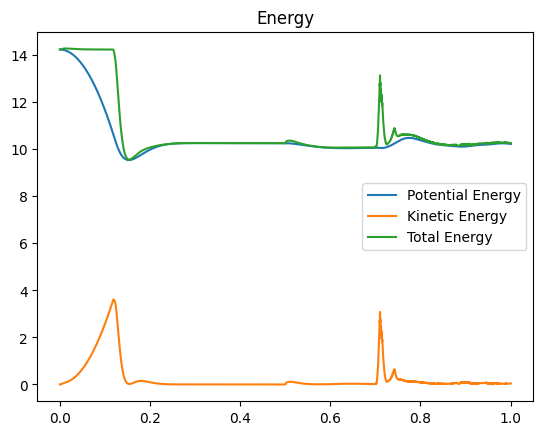

In [17]:
#plt.plot(time,energy[:,0],label='Potential Energy')
#plt.plot(time,energy[:,1],label='Kinetic Energy')
plt.plot(time,energy[:,2],label='Total Energy')
plt.legend()
plt.title("Energy")